## Purpose
1. To understand mechanisms for encoding inputs with good information efficiency.

## Perceived Advantages
1. The encoding can represent various features of the input which are easier to analyse
2. The encoding can be used for further tasks
3. It can be used for dimensionality reduction if the encoding has fewer dimensions than input
4. The decoder can be used for generating samples.

## Theory and Motivation
To learn functions E and D s.t Z = E(X),Y = D(Z) dist(Y,X) is minimum. If Z has fewer dimensions than X then the learned functions are expected to learn the most relevant features of the input.
If Z has more dimensions than X then the system is said to be overcomplete and the learned functions have the risk of being identity functions which overfit the training set and doesnt capture input characteristics. In this work we will analyse both undercomplete and overcomplete systems.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as tfunc
from torch.utils.data import dataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import seaborn as sns
sys.path.append('../')
%matplotlib inline

In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(10,(0.02,0.02)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])


mnist_X = torchvision.datasets.MNIST("./mnist",train=True,download=True,transform=train_transforms)
mnist_length = mnist_X.__len__()
mnist_train,mnist_val = dataset.random_split(mnist_X,[int(0.9*mnist_length),mnist_length-int(0.9*mnist_length)])
mnist_test = torchvision.datasets.MNIST("./mnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

fmnist_X = torchvision.datasets.FashionMNIST("./fmnist",train=True,download=True,transform=train_transforms)
fmnist_length = fmnist_X.__len__()
fmnist_train,fmnist_val = dataset.random_split(fmnist_X,[int(0.9*fmnist_length),fmnist_length-int(0.9*fmnist_length)])
fmnist_test = torchvision.datasets.FashionMNIST("./fmnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

emnist_X = torchvision.datasets.EMNIST("./emnist",split='balanced',train=True,download=True,transform=train_transforms)
emnist_length = emnist_X.__len__()
emnist_train,emnist_val = dataset.random_split(emnist_X,[int(0.9*emnist_length),emnist_length-int(0.9*emnist_length)])
emnist_test = torchvision.datasets.EMNIST("./emnist",split='balanced',train=False,download=True,transform=torchvision.transforms.ToTensor())



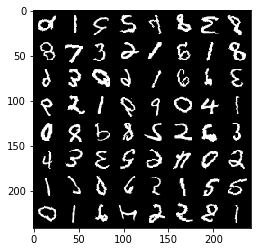

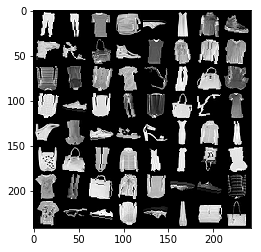

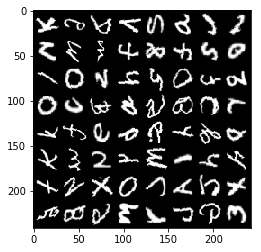

In [3]:
def plt_image(inp) :
    inp = torchvision.utils.make_grid(inp)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
def imshow(dataset) :
    inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)))
    plt_image(inp)
    
imshow(mnist_train)
imshow(fmnist_train)
imshow(emnist_train)

In [4]:
import torch.optim as optim
def train(encoder,decoder,dataset,loss_fn,lr) :
    optimizer_enc = optim.Adam(encoder.parameters(),lr)
    optimizer_dec = optim.Adam(decoder.parameters(),lr)
    encoder.train()
    decoder.train()
    for x,_ in dataset :
        x = x.cuda()
        z = encoder(x)
        y = decoder(z)
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()        
        loss_fn(x,y,z).mean().backward()
        optimizer_enc.step()
        optimizer_dec.step()
        

def inference(encoder,decoder,dataset,loss_fn) :
    loss = 0
    with torch.no_grad() :
        encoder.eval()
        decoder.eval()
        for x,_ in dataset :
            x  = x.cuda()
            z = encoder(x)
            y = decoder(z)
            loss += loss_fn(x,y,z).sum().item()
    return loss/dataset.dataset.__len__()

def run_epoch(encoder,decoder,lr,batch_size,loss_fn,train_dataset,val_dataset,test_dataset,max_epochs) :
    train_losses = []
    val_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=False,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=batch_size)

    for i in range(max_epochs+1) :
        train(encoder,decoder,train_loader,loss_fn,lr)
        if i%10 == 0 :
            train_losses.append(inference(encoder,decoder,train_loader,loss_fn))
            val_losses.append(inference(encoder,decoder,val_loader,loss_fn))
            test_losses.append(inference(encoder,decoder,test_loader,loss_fn))
            print("Epoch {}: {} {} {}".format(i,train_losses[-1],val_losses[-1],test_losses[-1]))
    return train_losses,val_losses,test_losses
       

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self,latent_dims,final_dims):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(latent_dims,final_dims,bias=False)
        )
    def forward(self, x):
        x= x.view(x.shape[0],-1)
        x = torch.sigmoid(self.decode(x))
        return x
    
    
class Encoder(torch.nn.Module):
    def __init__(self,inp_dims,latent_dims):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(inp_dims,latent_dims),
        )
    def forward(self, x, flag=True):
        x= x.view(x.shape[0],-1)
        x  = torch.tanh(self.encode(x))
        return x


In [6]:
def reconstruction_loss(x,y,z) :
    x = x.view(x.shape[0],-1).type_as(z)
    y = y.view(x.shape[0],-1)
    z = z.view(x.shape[0],-1)
    inter = (x*y).sum(dim=1)
    union = (x+y).sum(dim=1)
    return 1 - (2*inter/union)




In [7]:

def get_encodings(encoder,dataset,batch_size) :
    torch.cuda.empty_cache()
    encoding = []
    loader = torch.utils.data.DataLoader(dataset,shuffle=False,batch_size=batch_size)
    with torch.no_grad() :
        encoder.eval()
        for x,_ in loader :
            x  = x.cuda()
            z = encoder(x).cpu().numpy()
            encoding.append(z)
    return np.vstack(encoding)

def analyse_encoding(decoder,encodings,batch_size) :
    encodings_dev = np.std(encodings,axis=0)
    plt.plot(encodings_dev)
    plt.title("deviation plots")
    plt.show()

    torch.cuda.empty_cache()
    dataset = torch.utils.data.TensorDataset(torch.tensor(encodings.astype(np.float32)))
    loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=batch_size)
    with torch.no_grad() :
        decoder.eval()
        z = next(iter(loader))[0].numpy()
        y = decoder(torch.Tensor(z).cuda()).cpu().view(z.shape[0],1,28,28)
        plt_image(y)
        for i in range(z.shape[1]) :
            mask = np.ones([1,z.shape[1]])
            mask[0,i] = 0
            vals = np.linspace(-1,1,10) 
            for val in  vals :
                copy = z*mask + mask*val
                y = decoder(torch.Tensor(copy).cuda()).cpu().view(z.shape[0],1,28,28)
                plt_image(y)
            print("Plotted feature ",i)

Epoch 0: 0.5250115305229469 0.5241278648376465 0.5126218388080597
Epoch 10: 0.3684817360772027 0.3676729284922282 0.3537361132621765
Epoch 20: 0.274302218525498 0.27386825847625734 0.25850546667575836
Epoch 30: 0.23475727683526498 0.23491713253657023 0.21965968363285066
Epoch 40: 0.21449801061771534 0.21440854517618815 0.20005339283943177
Epoch 50: 0.2016841565767924 0.20177550268173217 0.18787203905582428
Epoch 60: 0.1934592940542433 0.19345258967081705 0.17990591034889222
Epoch 70: 0.1875621309103789 0.18764475282033286 0.1744459107875824
Epoch 80: 0.1831100308453595 0.18325671609242758 0.170148659992218
Epoch 90: 0.17959575340482925 0.17965945609410605 0.16688499274253846
Epoch 100: 0.17684763013875043 0.17703272453943888 0.16426916115283965
Epoch 110: 0.17450802412739508 0.1746512106259664 0.1619212365627289
Epoch 120: 0.17243623737052635 0.17272010040283203 0.16001598255634308
Epoch 130: 0.17058442089292739 0.17071122694015503 0.15828445353507994
Epoch 140: 0.16886457975705466 0.1

Text(0.5,0,'epochs//10')

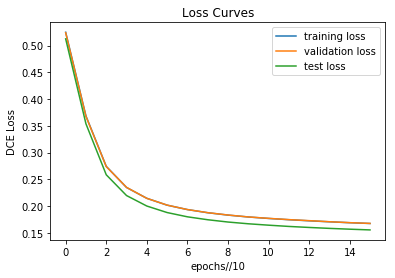

In [8]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
mnist_net_decoder = Decoder(64,28*28).cuda()
mnist_net_encoder = Encoder(28*28,64).cuda()
tl,vl,tel = run_epoch(mnist_net_encoder,mnist_net_decoder,1e-4,64,reconstruction_loss,mnist_train,mnist_val,mnist_test,150)
torch.save(mnist_net_decoder.state_dict(),'mnist_net_dec.mod')
torch.save(mnist_net_encoder.state_dict(),'mnist_net_enc.mod')
plt.plot(tl)
plt.plot(vl)
plt.plot(tel)
plt.legend(["training loss","validation loss","test loss"])
plt.title("Loss Curves")
plt.ylabel("DCE Loss")
plt.xlabel("epochs//10")

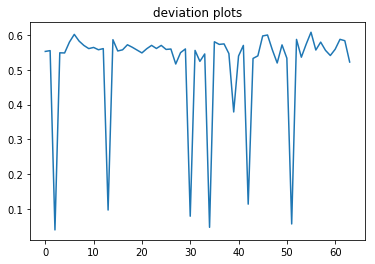

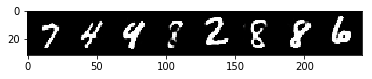

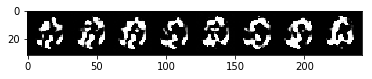

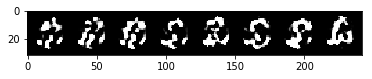

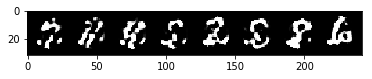

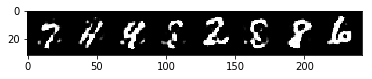

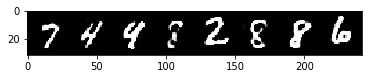

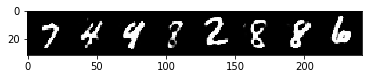

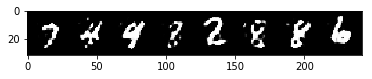

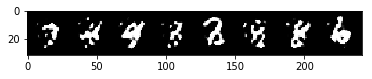

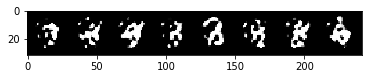

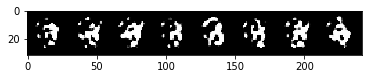

Plotted feature  0


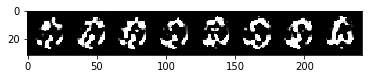

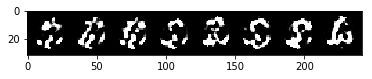

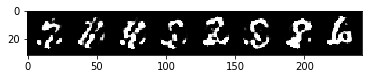

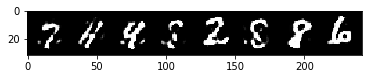

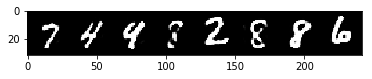

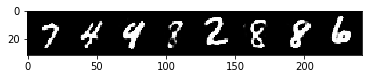

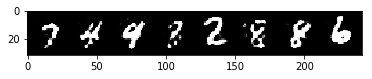

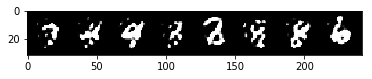

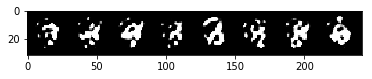

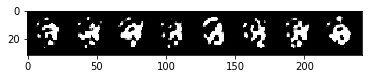

Plotted feature  1


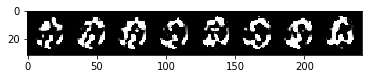

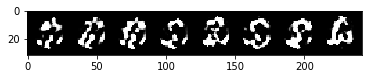

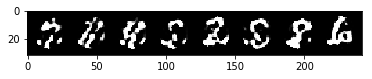

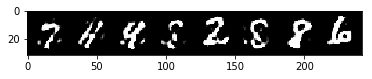

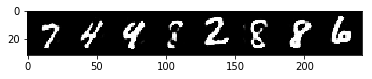

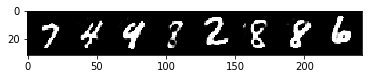

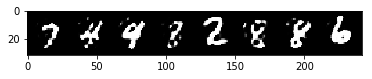

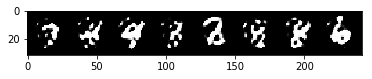

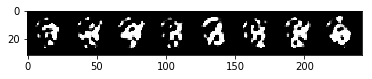

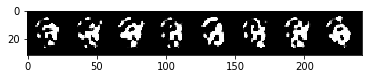

Plotted feature  2


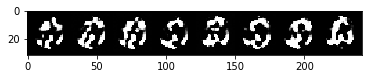

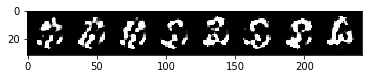

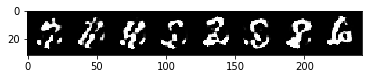

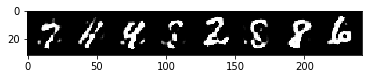

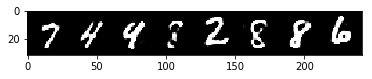

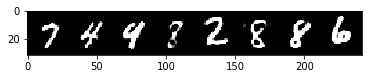

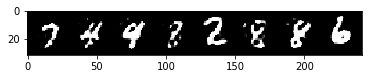

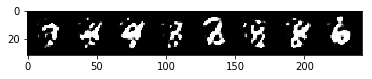

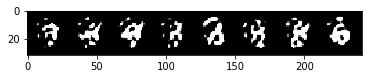

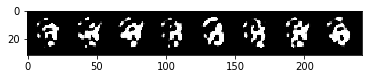

Plotted feature  3


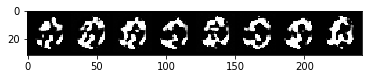

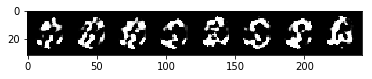

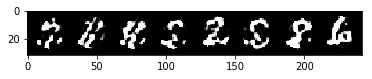

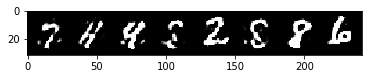

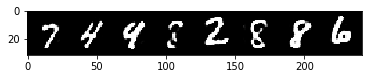

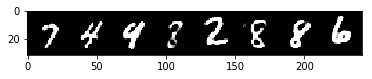

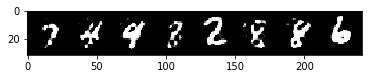

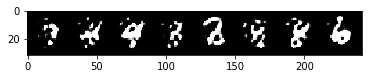

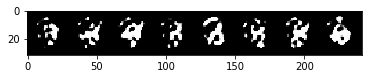

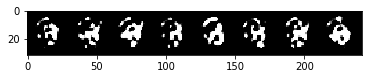

Plotted feature  4


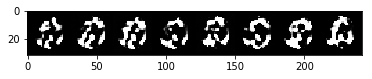

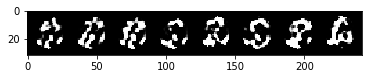

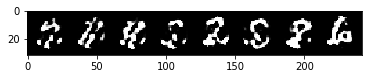

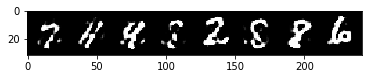

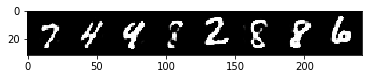

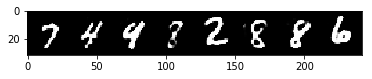

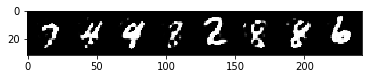

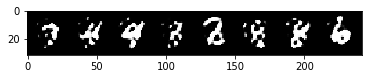

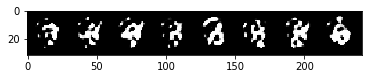

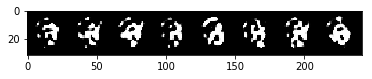

Plotted feature  5


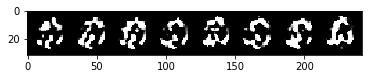

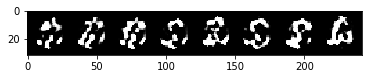

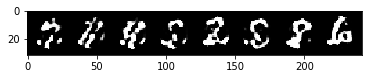

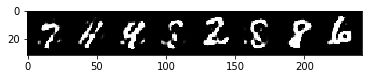

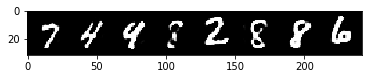

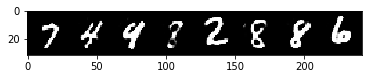

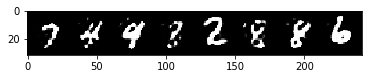

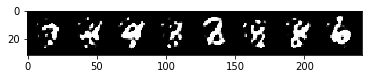

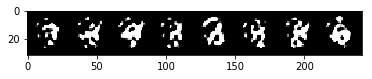

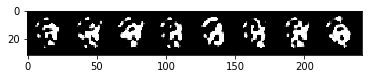

Plotted feature  6


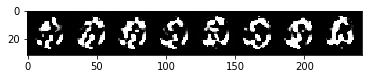

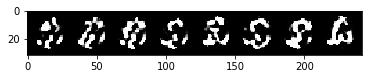

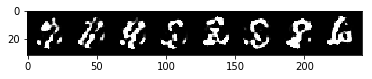

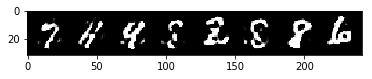

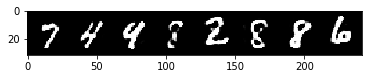

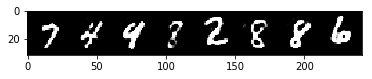

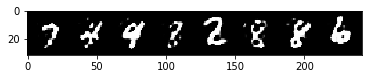

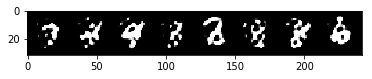

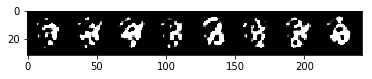

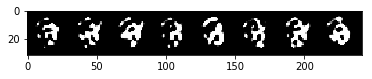

Plotted feature  7


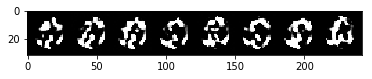

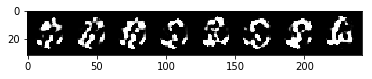

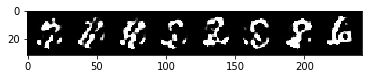

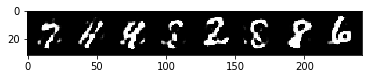

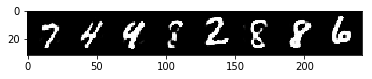

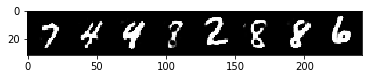

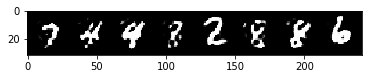

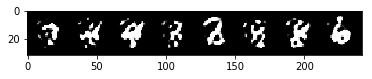

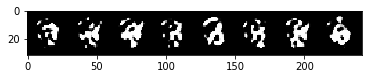

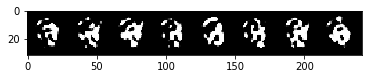

Plotted feature  8


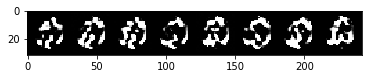

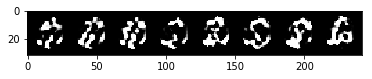

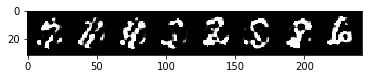

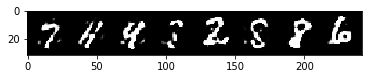

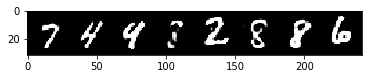

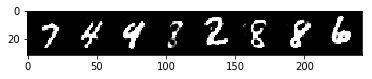

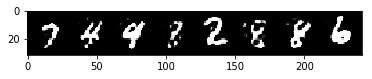

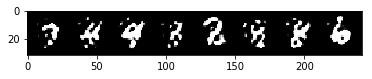

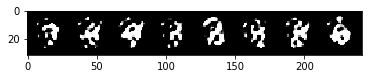

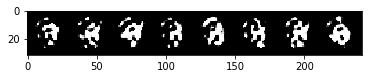

Plotted feature  9


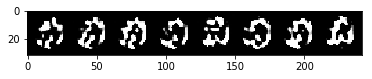

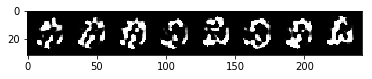

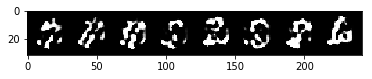

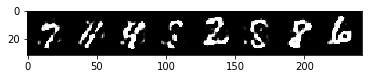

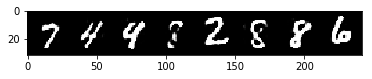

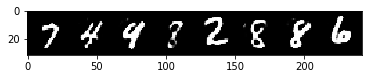

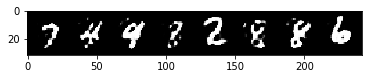

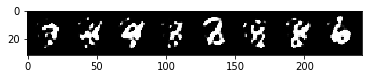

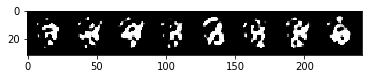

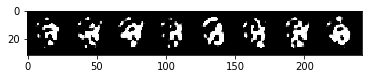

Plotted feature  10


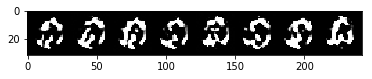

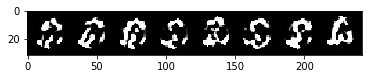

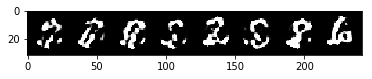

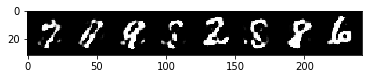

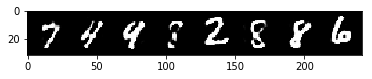

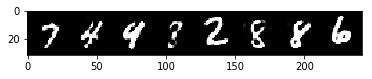

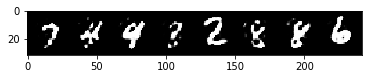

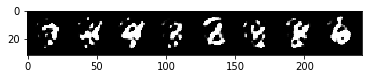

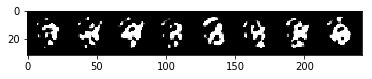

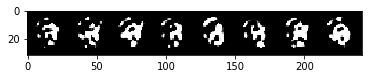

Plotted feature  11


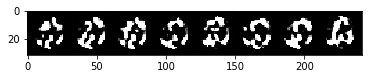

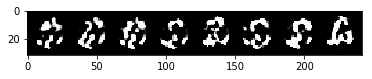

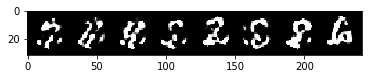

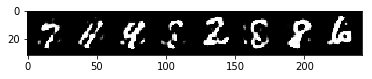

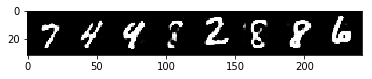

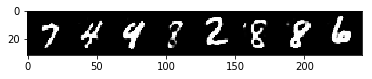

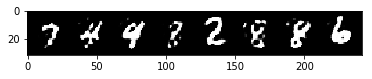

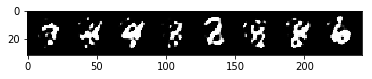

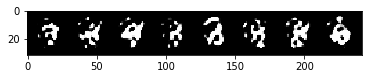

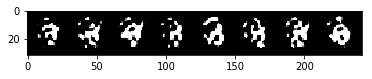

Plotted feature  12


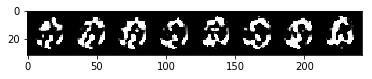

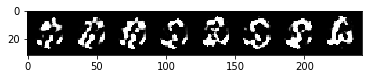

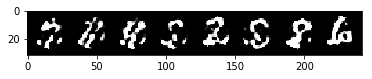

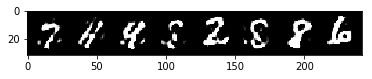

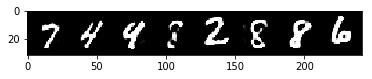

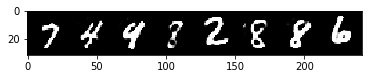

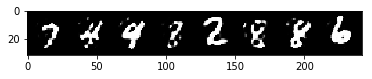

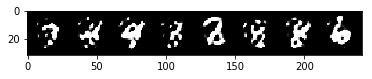

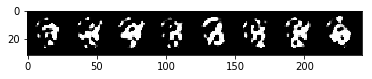

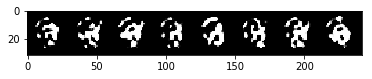

Plotted feature  13


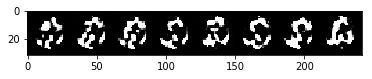

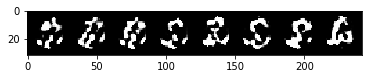

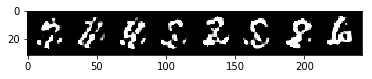

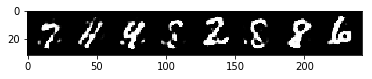

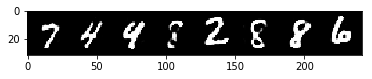

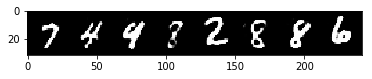

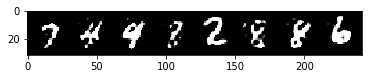

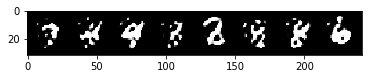

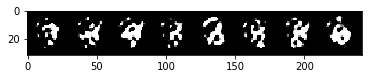

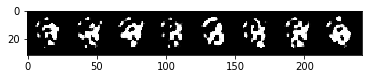

Plotted feature  14


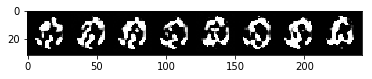

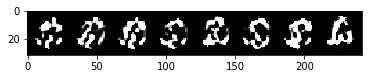

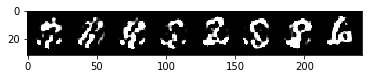

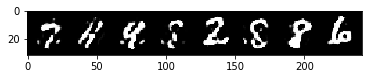

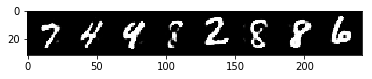

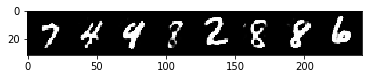

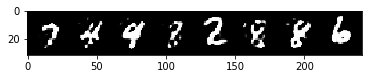

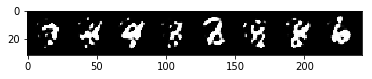

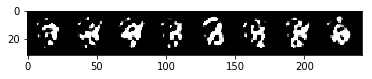

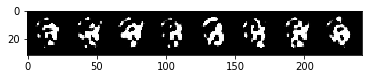

Plotted feature  15


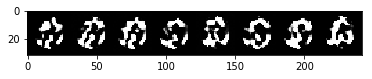

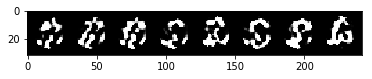

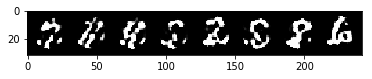

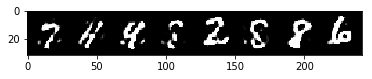

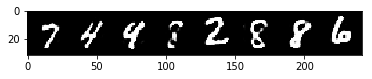

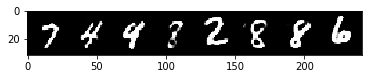

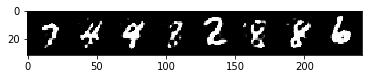

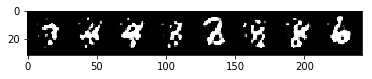

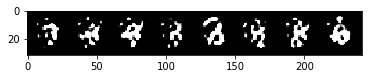

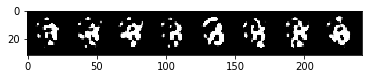

Plotted feature  16


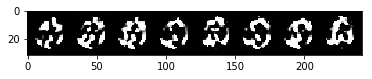

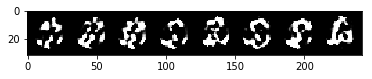

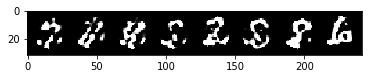

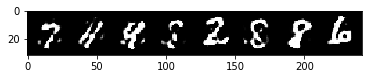

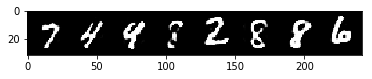

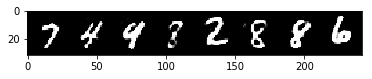

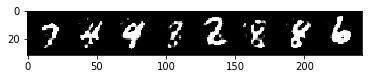

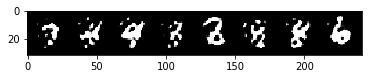

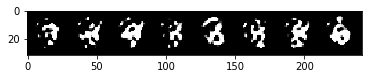

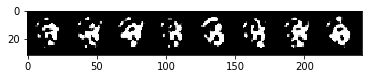

Plotted feature  17


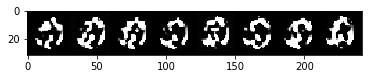

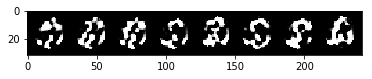

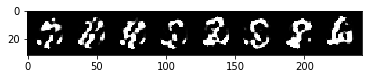

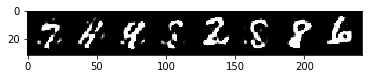

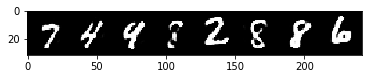

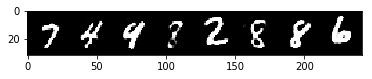

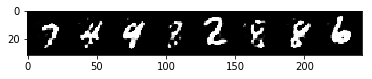

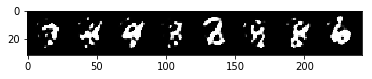

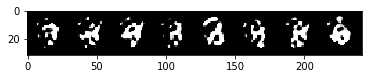

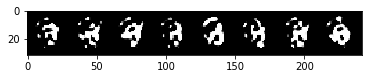

Plotted feature  18


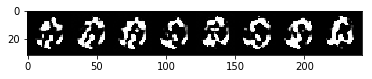

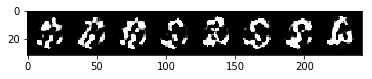

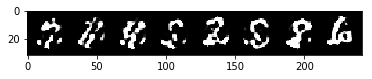

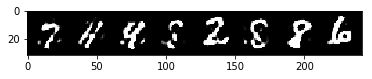

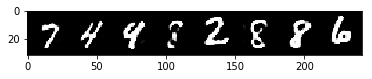

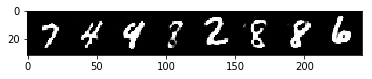

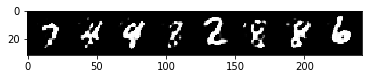

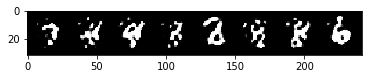

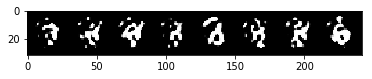

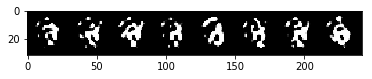

Plotted feature  19


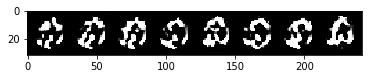

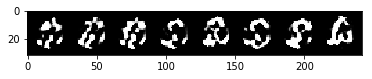

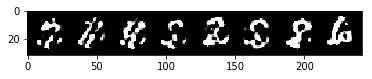

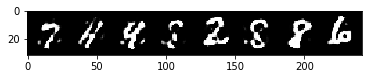

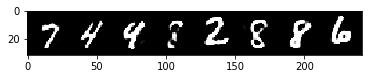

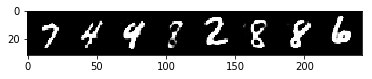

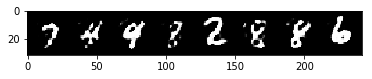

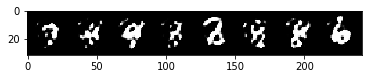

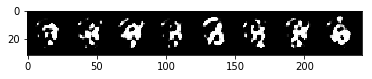

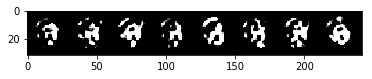

Plotted feature  20


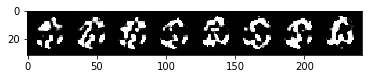

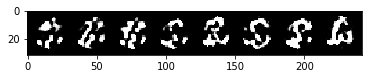

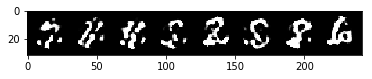

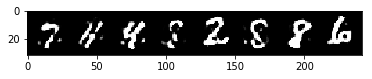

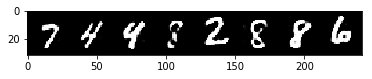

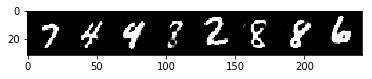

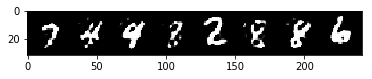

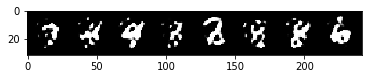

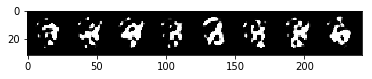

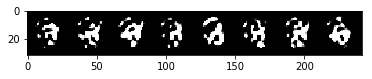

Plotted feature  21


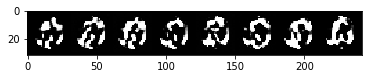

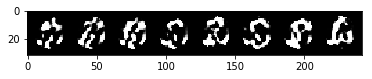

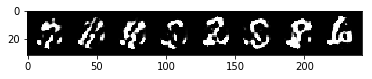

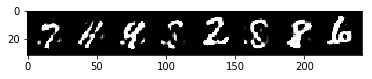

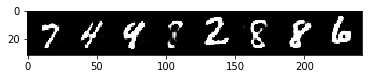

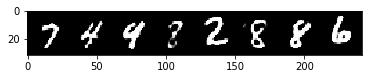

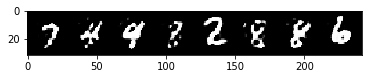

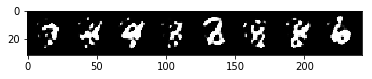

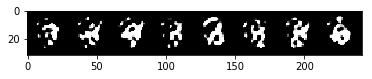

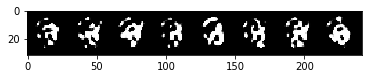

Plotted feature  22


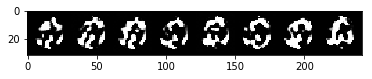

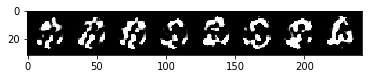

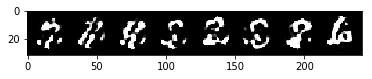

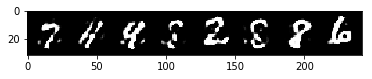

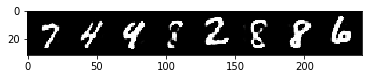

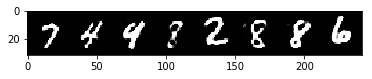

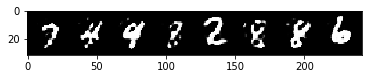

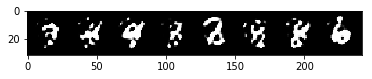

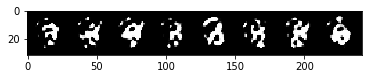

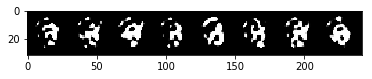

Plotted feature  23


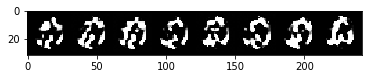

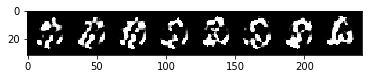

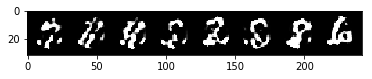

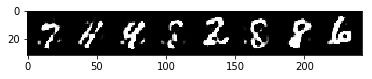

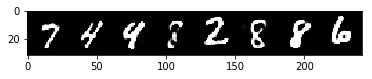

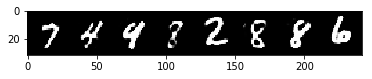

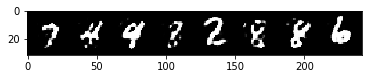

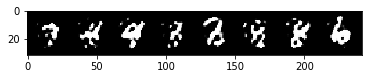

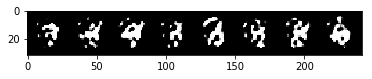

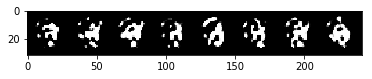

Plotted feature  24


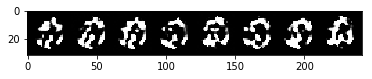

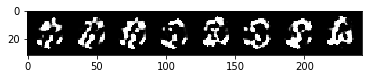

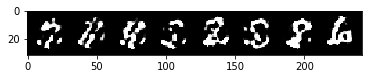

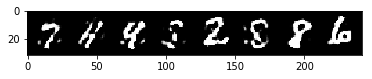

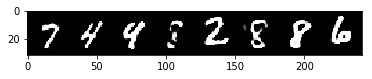

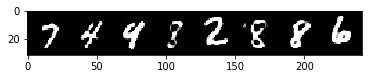

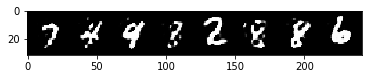

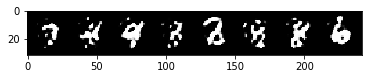

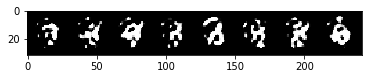

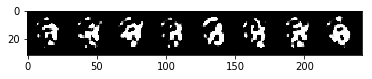

Plotted feature  25


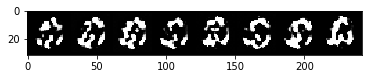

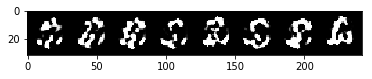

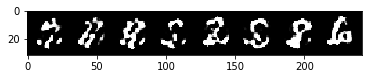

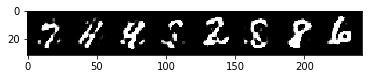

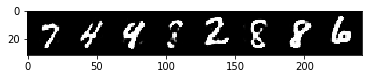

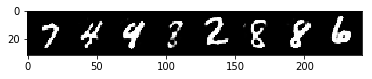

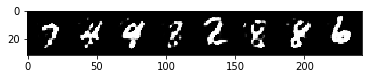

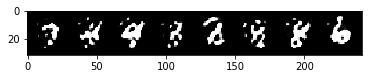

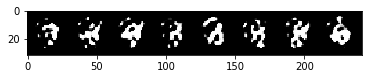

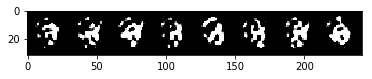

Plotted feature  26


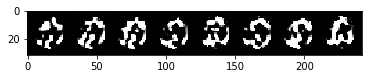

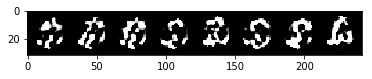

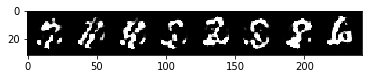

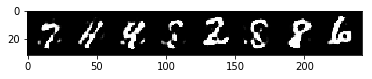

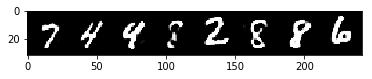

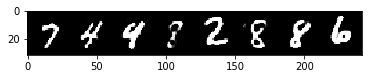

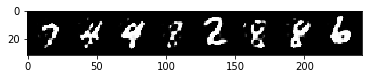

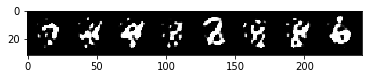

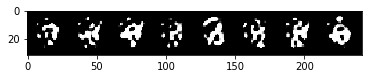

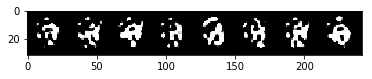

Plotted feature  27


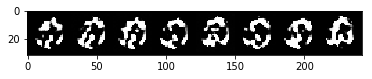

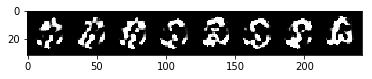

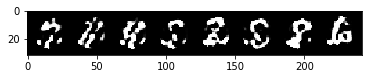

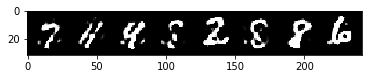

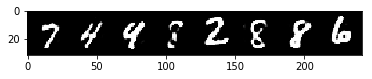

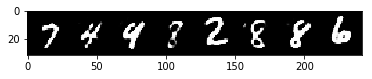

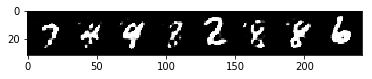

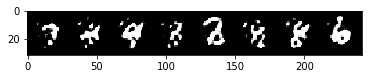

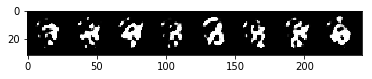

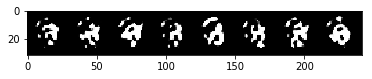

Plotted feature  28


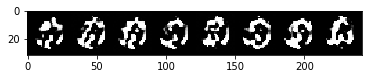

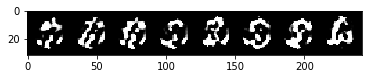

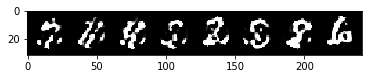

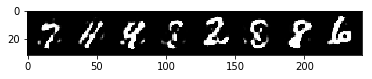

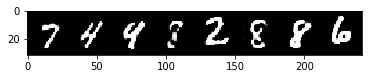

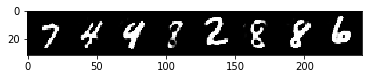

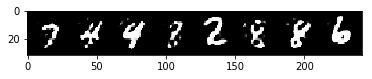

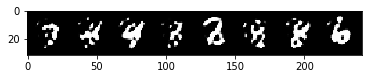

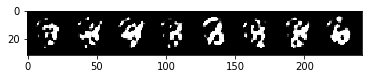

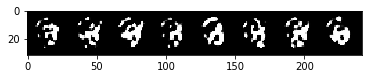

Plotted feature  29


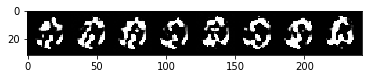

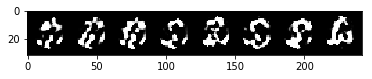

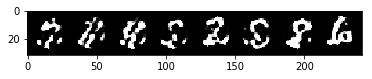

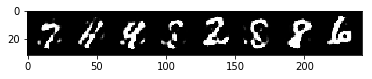

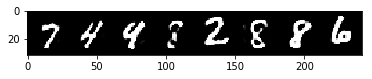

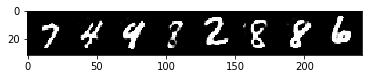

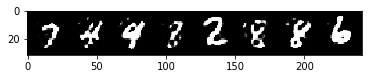

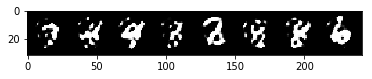

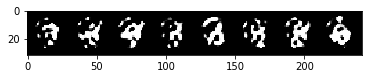

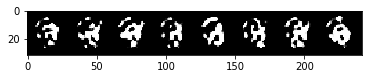

Plotted feature  30


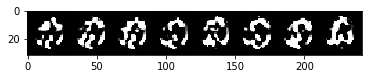

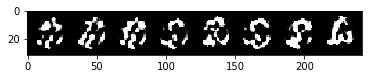

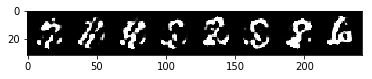

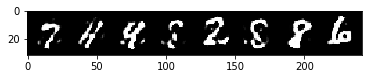

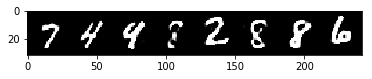

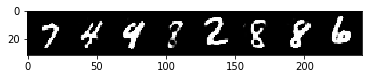

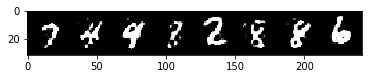

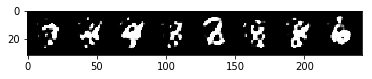

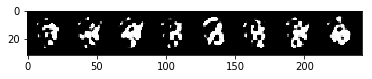

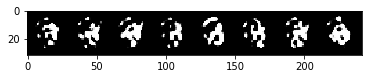

Plotted feature  31


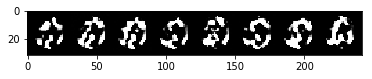

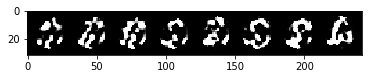

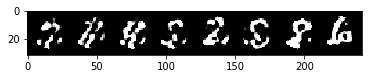

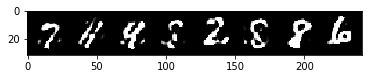

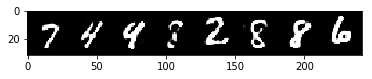

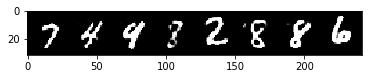

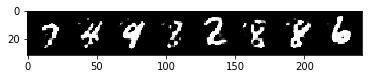

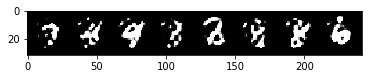

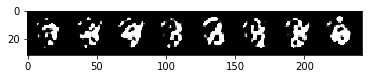

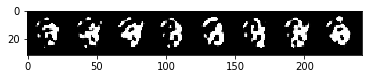

Plotted feature  32


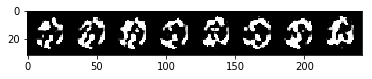

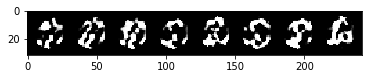

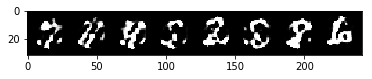

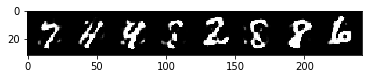

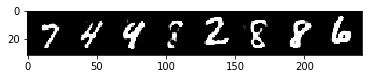

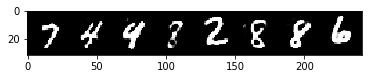

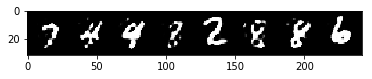

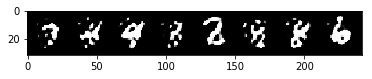

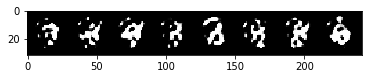

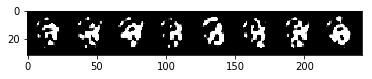

Plotted feature  33


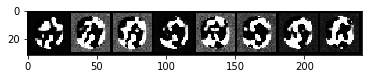

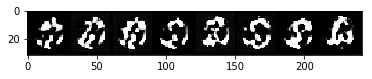

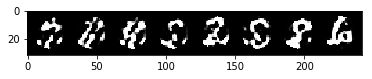

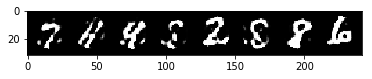

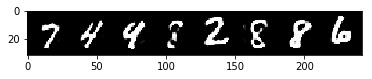

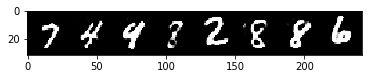

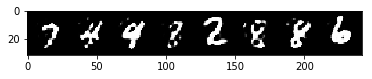

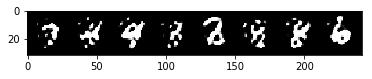

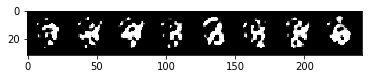

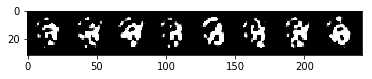

Plotted feature  34


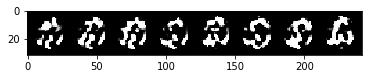

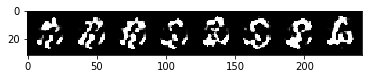

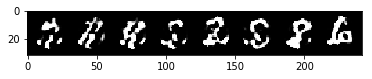

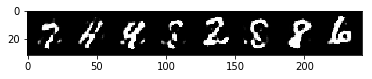

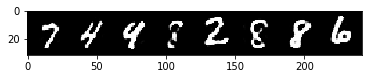

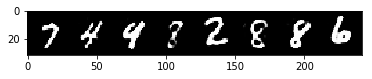

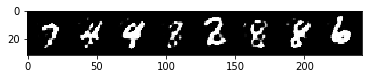

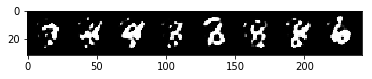

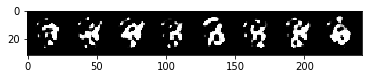

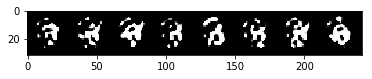

Plotted feature  35


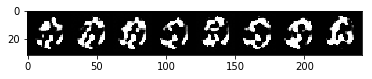

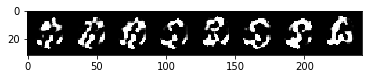

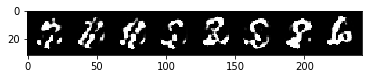

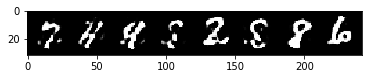

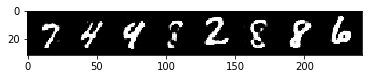

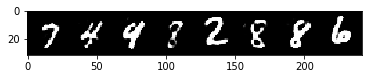

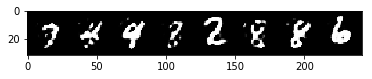

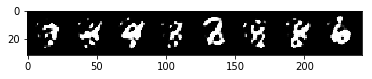

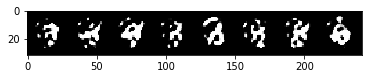

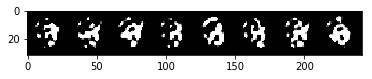

Plotted feature  36


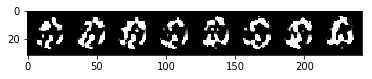

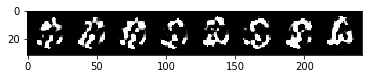

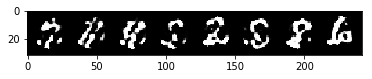

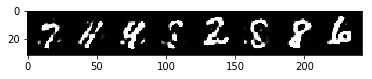

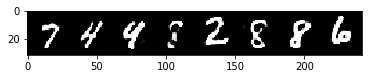

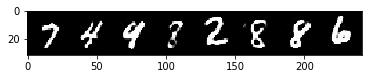

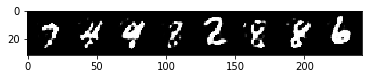

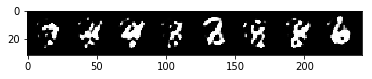

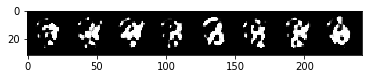

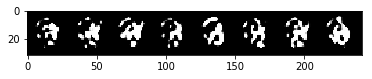

Plotted feature  37


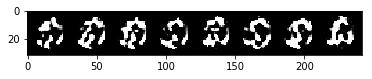

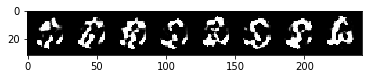

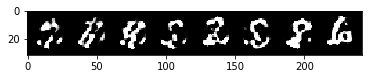

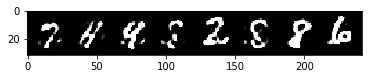

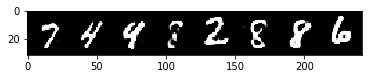

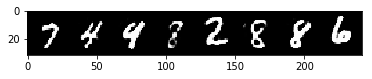

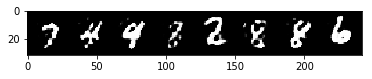

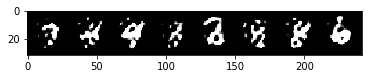

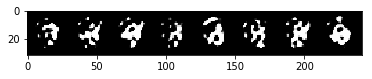

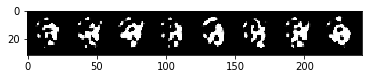

Plotted feature  38


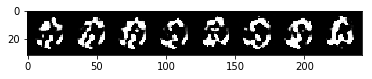

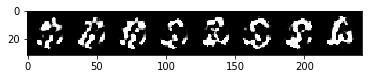

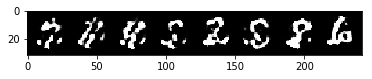

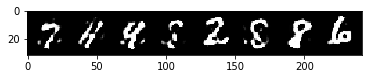

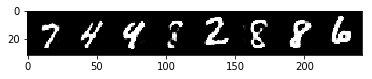

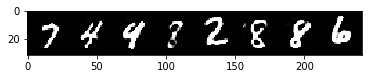

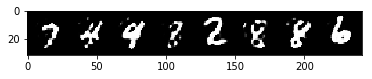

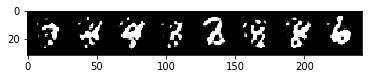

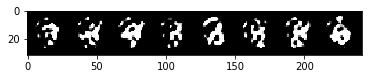

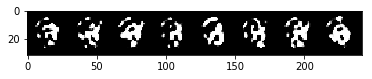

Plotted feature  39


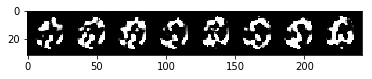

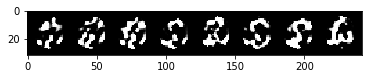

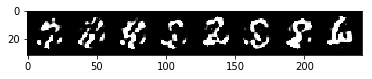

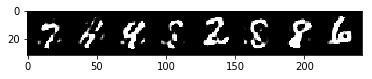

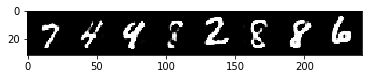

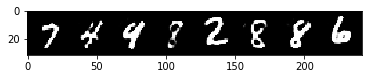

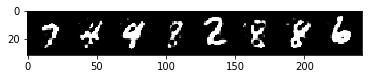

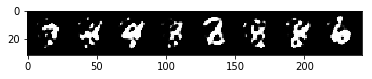

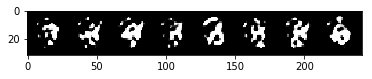

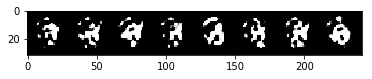

Plotted feature  40


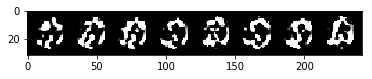

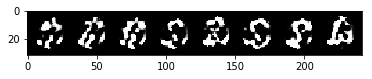

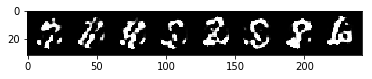

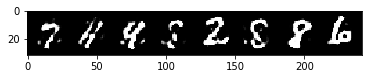

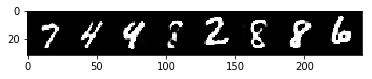

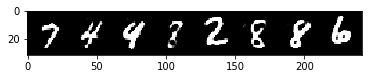

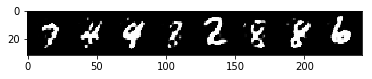

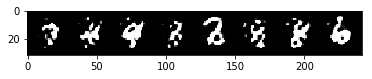

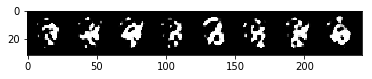

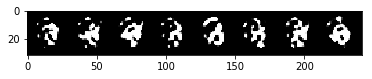

Plotted feature  41


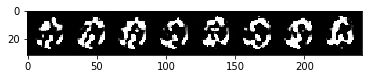

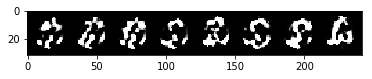

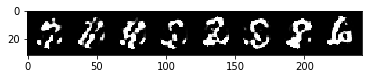

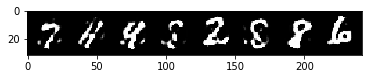

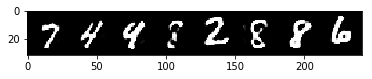

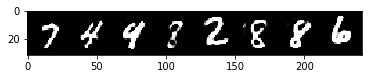

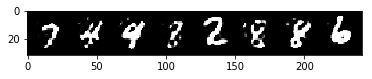

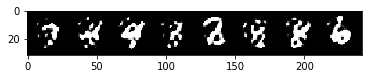

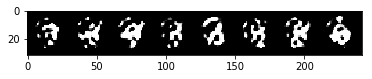

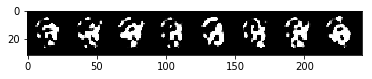

Plotted feature  42


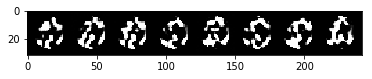

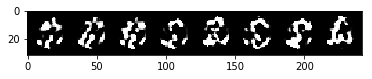

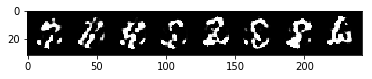

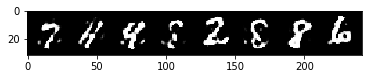

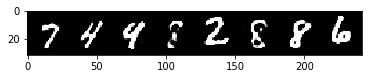

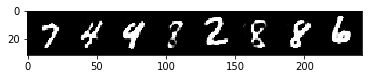

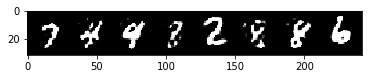

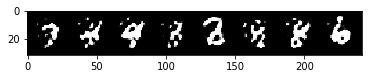

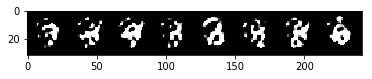

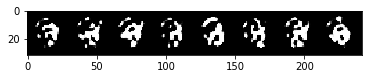

Plotted feature  43


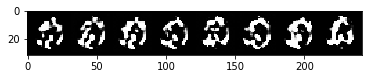

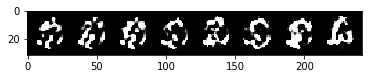

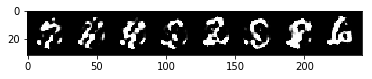

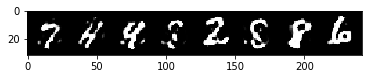

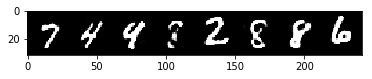

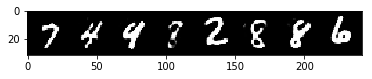

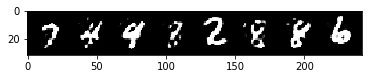

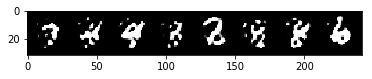

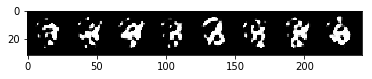

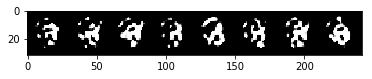

Plotted feature  44


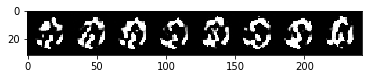

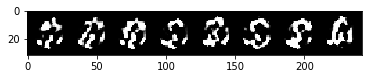

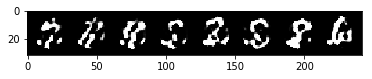

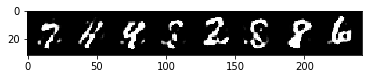

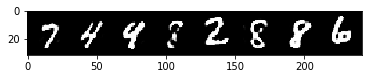

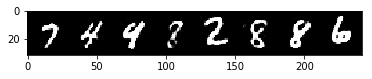

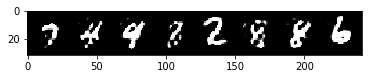

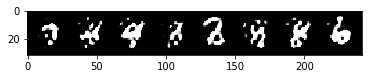

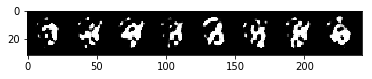

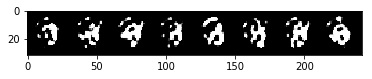

Plotted feature  45


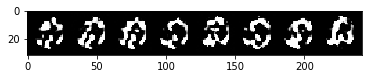

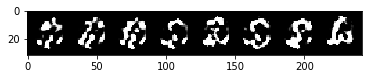

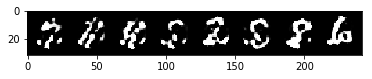

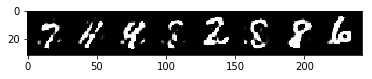

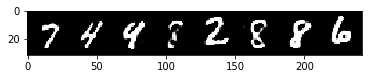

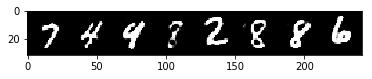

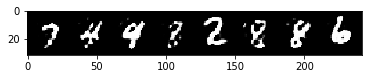

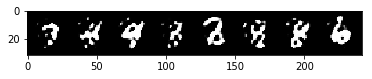

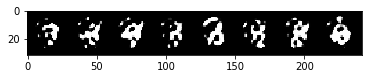

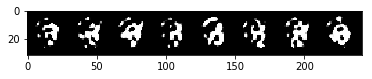

Plotted feature  46


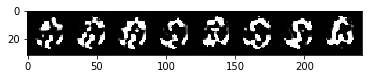

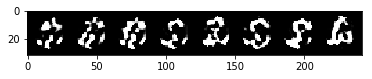

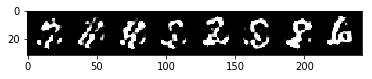

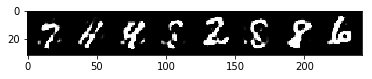

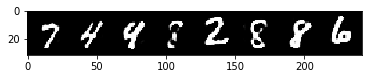

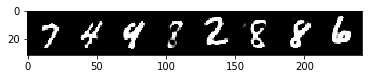

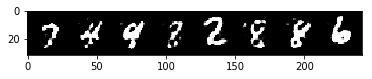

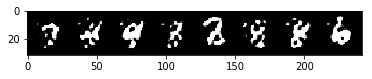

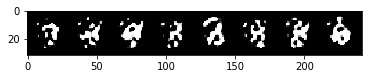

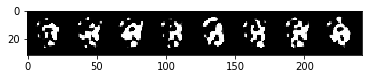

Plotted feature  47


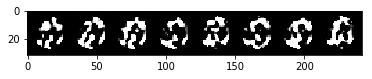

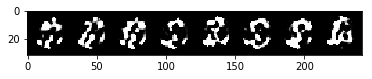

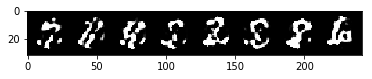

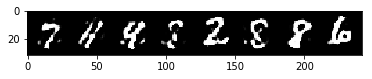

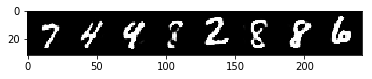

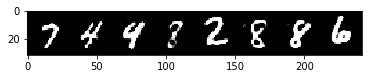

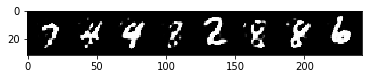

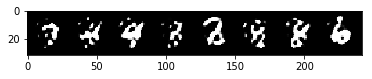

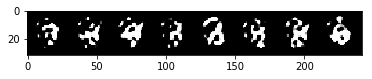

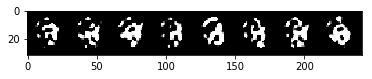

Plotted feature  48


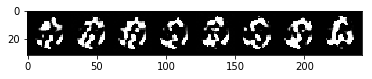

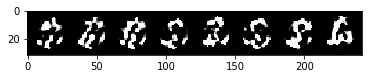

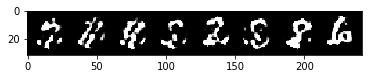

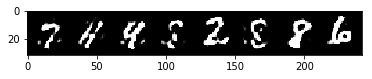

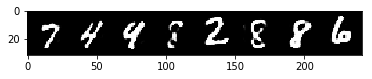

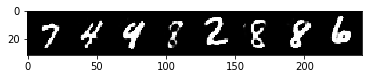

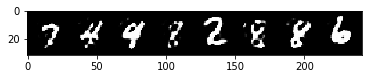

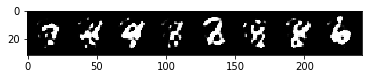

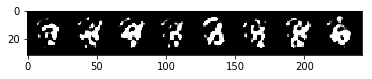

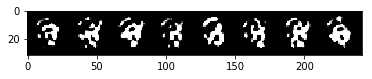

Plotted feature  49


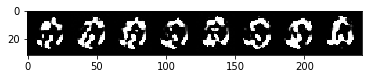

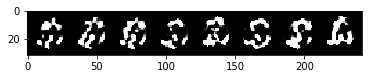

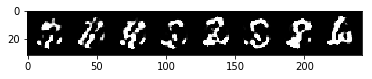

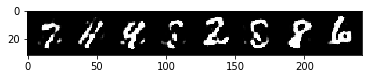

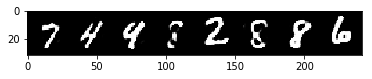

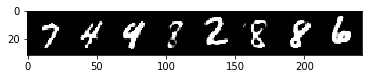

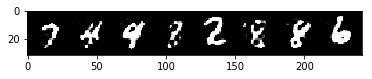

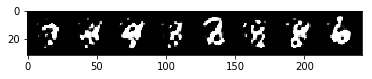

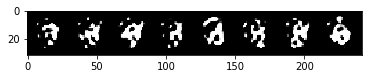

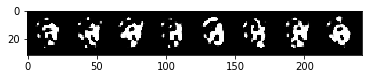

Plotted feature  50


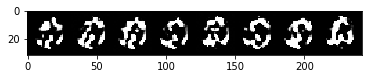

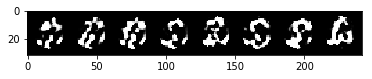

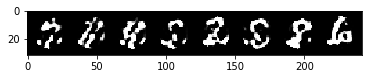

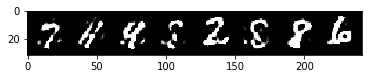

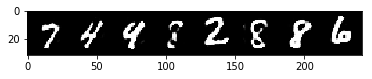

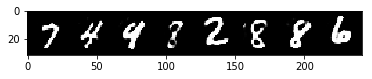

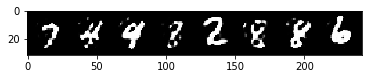

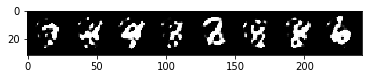

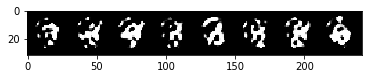

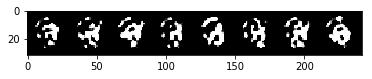

Plotted feature  51


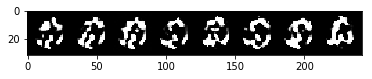

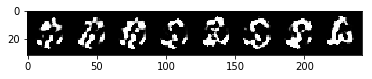

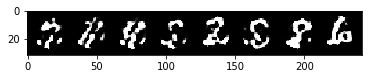

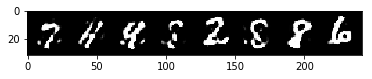

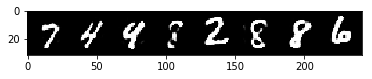

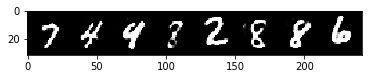

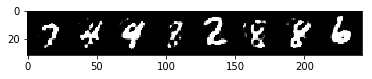

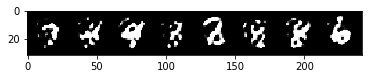

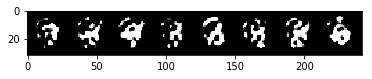

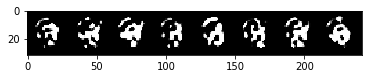

Plotted feature  52


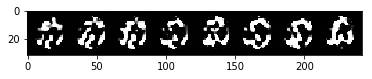

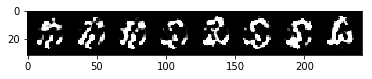

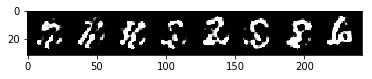

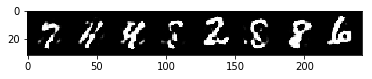

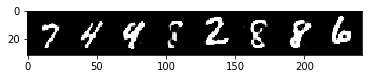

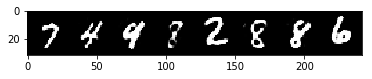

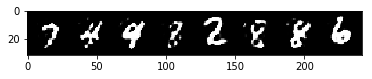

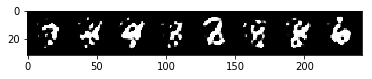

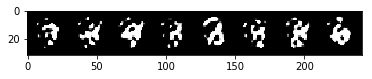

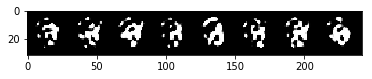

Plotted feature  53


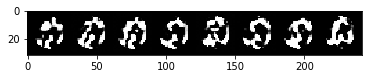

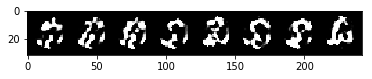

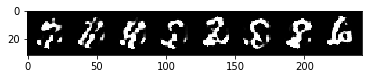

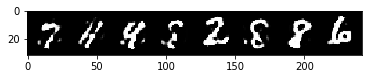

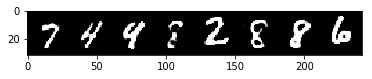

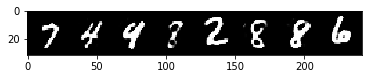

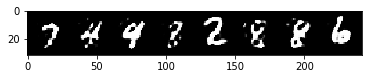

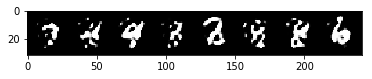

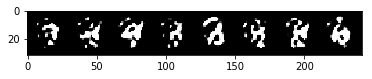

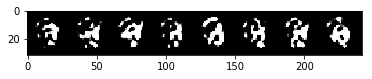

Plotted feature  54


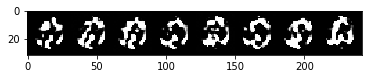

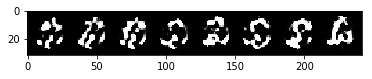

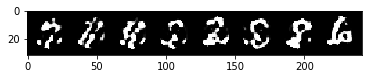

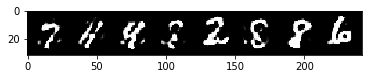

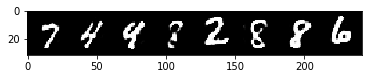

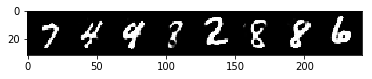

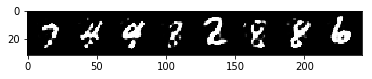

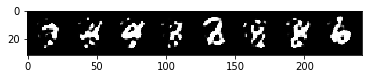

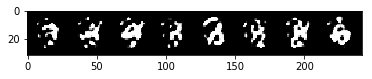

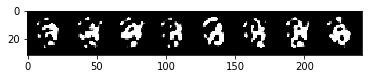

Plotted feature  55


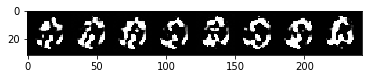

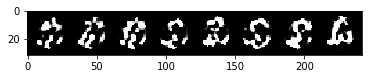

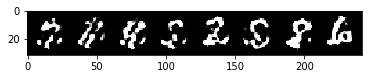

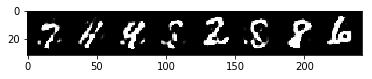

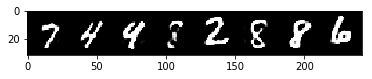

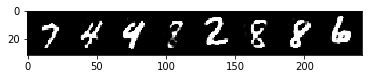

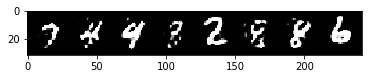

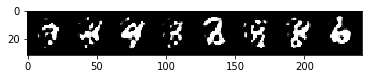

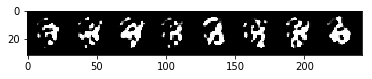

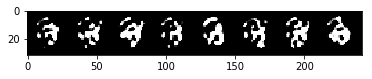

Plotted feature  56


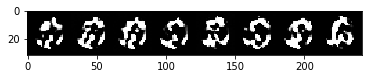

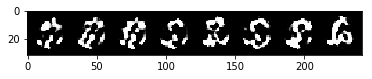

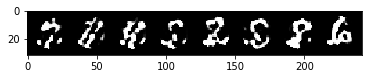

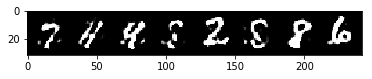

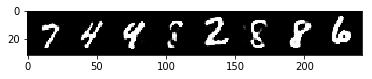

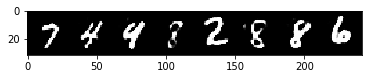

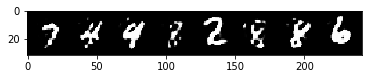

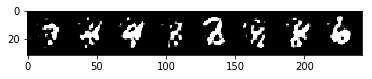

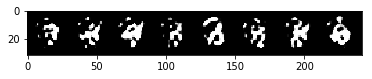

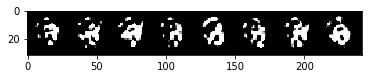

Plotted feature  57


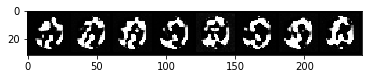

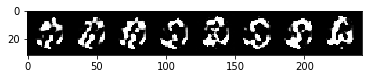

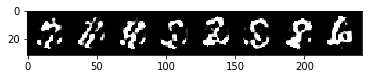

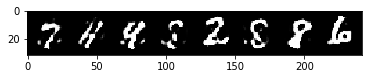

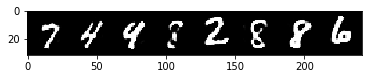

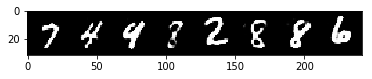

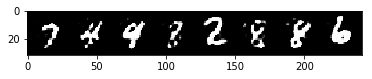

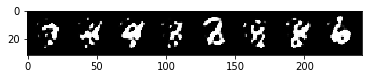

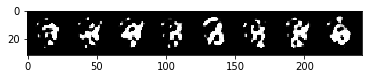

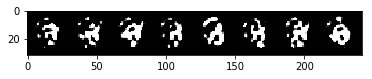

Plotted feature  58


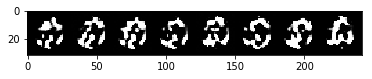

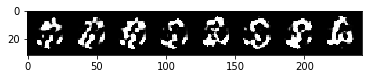

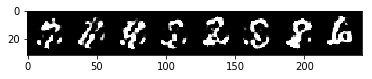

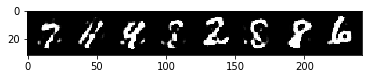

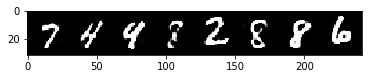

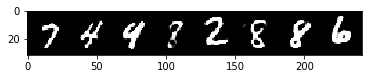

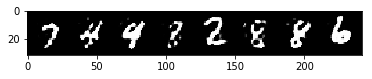

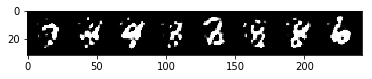

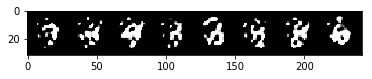

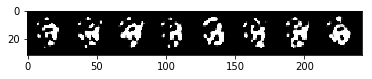

Plotted feature  59


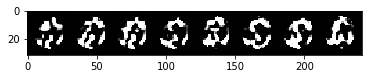

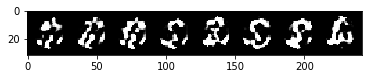

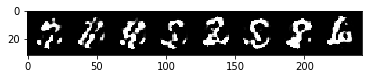

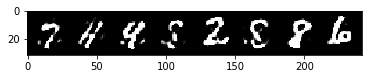

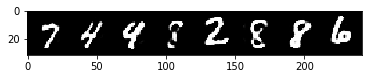

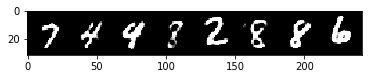

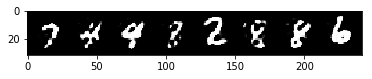

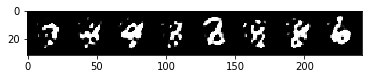

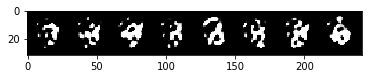

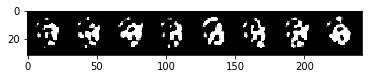

Plotted feature  60


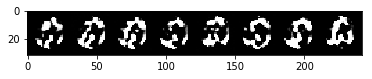

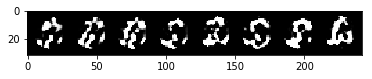

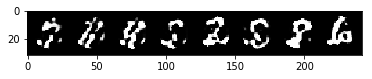

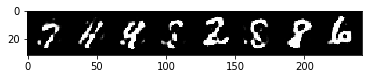

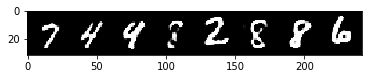

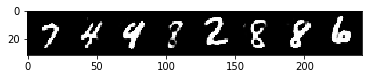

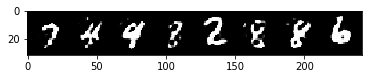

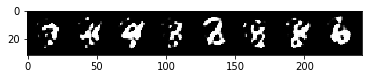

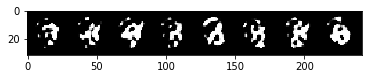

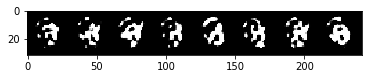

Plotted feature  61


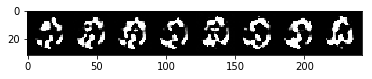

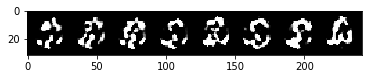

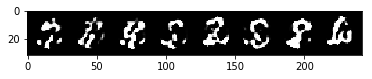

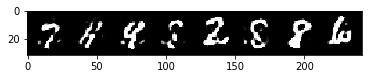

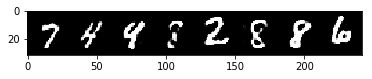

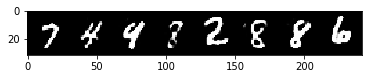

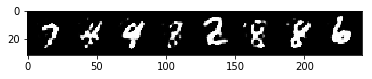

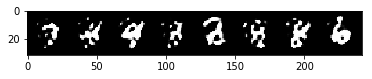

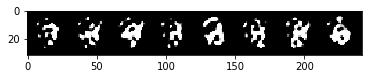

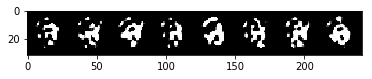

Plotted feature  62


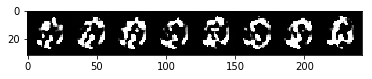

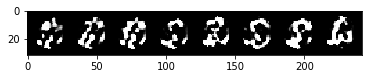

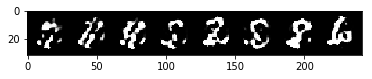

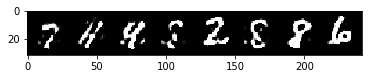

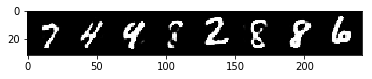

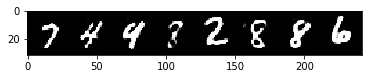

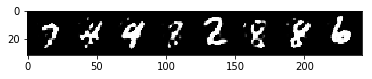

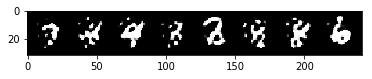

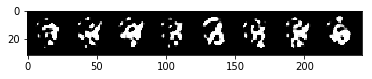

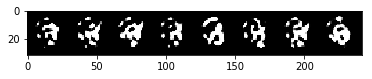

Plotted feature  63


In [9]:
mnist_net_decoder = Decoder(64,28*28).cuda()
mnist_net_encoder = Encoder(28*28,64).cuda()
mnist_net_encoder.load_state_dict(torch.load("mnist_net_enc.mod"))
mnist_net_decoder.load_state_dict(torch.load("mnist_net_dec.mod"))
encodings = get_encodings(mnist_net_encoder,mnist_test,256)
analyse_encoding(mnist_net_decoder,encodings,8)

## Observation
1. Most of the features have a high standard deviation, suggesting they are useful.
2. The features are highly inter-dependent as changes in even one of the features affect the entire decoding process.